In [1]:
# set up matplotlib
%matplotlib widget
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams.update({"font.size": 14})

In [2]:
import numpy as np
import xarray as xr
from scipy.interpolate import RectBivariateSpline
from xbout import open_boutdataset

In [3]:
case = "1" # 4 and 9  have n,t,p data
filepath = "test" + str(case) + "/BOUT.dmp.0.nc"
#filepath = "test" + str(case) + "/BOUT.dmp.0.nc"

ds = open_boutdataset(datapath="test" + str(case) + "/BOUT.dmp.*.nc", chunks={"t": 4})
dsn = xr.open_dataset("tokamak_lowres.fci.nc")

# Use squeeze() to get rid of the y-dimension, which has length 1 as blob2d does not
# simulate the parallel dimension.
ds = ds.squeeze(drop=True)
dsn = dsn.squeeze(drop=True)

Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset> Size: 8MB
Dimensions:             (x: 68, y: 1, z: 68, t: 201)
Coordinates:
    dx                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    dy                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    dz                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
  * t                   (t) float64 2kB 0.0 5e+05 1e+06 ... 9.95e+07 1e+08
  * x                   (x) int64 544B 0 1 2 3 4 5 6 7 ... 61 62 63 64 65 66 67
  * y                   (y) float64 8B 0.1963
  * z                   (z) float64 544B 0.007937 0.02381 ... 1.056 1.071
Data variables: (12/44)
    Bxy                 (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    G1                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    G2                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68)

/home/tirkas1/miniconda3/lib/python3.13/site-packages/xbout/load.py:646: UserWarning: The specified chunks separate the stored chunks along dimension "t" starting at index 4. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_mfdataset(
/home/tirkas1/miniconda3/lib/python3.13/site-packages/xbout/load.py:341: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")


In [4]:
dx = ds["dx"].isel(z=0).values

# Get rid of existing "x" coordinate, which is just the index values.
#ds = ds.drop("x")

# Create a new coordinate, which is length in units of rho_s
ds = ds.assign_coords(x=np.arange(ds.sizes["x"])*dx)

In [5]:
ds_initial = ds.isel(t=0)

In [6]:
for key,val in ds_initial.items():
    print(key)

Bxy
G1
G2
G3
J
Nh+
R
Z
cvode_last_order
cvode_last_step
cvode_nfevals
cvode_nliters
cvode_nniters
cvode_nonlin_fails
cvode_npevals
cvode_nsteps
cvode_num_fails
cvode_stab_lims
g11
g12
g13
g22
g23
g33
g_11
g_12
g_13
g_22
g_23
g_33
iteration
t_array
ncalls
ncalls_e
ncalls_i
wall_time
wtime
wtime_comms
wtime_invert
wtime_io
wtime_per_rhs
wtime_per_rhs_e
wtime_per_rhs_i
wtime_rhs


In [7]:
#For Dirichlet BCs.
dens = ds["Nh+"][:,2:-2,:]
dens_true = dens.copy()

mask = dsn["in_mask"][2:-2,:]
ghost_id = dsn["ghost_id"].values
bdy_pts = dsn["bndry_pts"].values
img_pts = dsn["image_pts"].values
is_plasma = dsn["is_plasma"].values
Rarr = dsn["R"].values[2:-2,:]
Zarr = dsn["Z"].values

#dens = dens.where(mask)
#dens_true = dens_true.where(mask)

spl = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[1,:,:], kx=1, ky=1)

In [10]:
bdy_pts_xz = spl.ev(bdy_pts[:,0], bdy_pts[:,1])
print(bdy_pts_xz)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]


Nh+ data passed has 3 dimensions - will use animatplot.blocks.Pcolormesh()


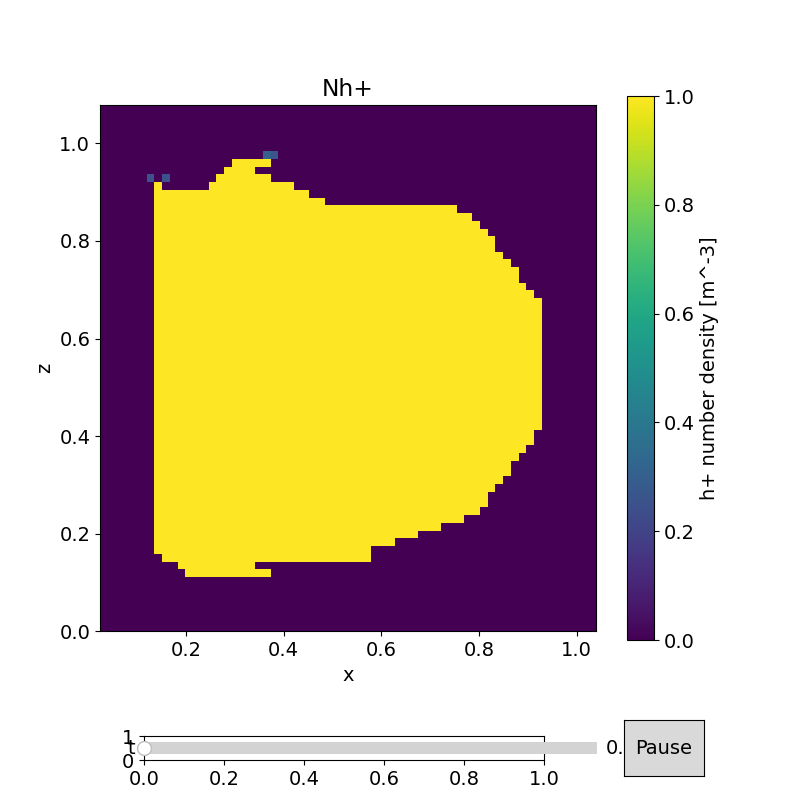

In [8]:
dens = ds["Nh+"][:,2:-2,:]
dens = dens.clip(min=0)
dens.bout.animate2D(aspect="equal")